# Making a Minecraft Tourist

In this assignment you will be making a neural network that can do image captioning.  This network will take in an image and produce a string of text describing what is found in the image.  To do this you will be constructing a relatively complicated neural network that will:

1. Use Convolutional Neural Networks (CNNs) to capture features from the images and condense it down to a vector of numbers that
2. a LSTM will use as its input, generating the caption in an auto-regressive manner

At the end of this assignment, you should understand:

1. How to construct your own custom Torch module (instead of using Sequential as you did last time)
2. How to combine multiple modules into one network
3. How to create a CNN
4. How to create an auto-regressive LSTM

First off, we have our import statements

Name: Kendall Haworth
Bronco ID: 011694826
Partner: Kenneth

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import pickle
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

Now we need to set up our dataset.  The data has been pickled for you (pickle is a Python specific serialization that works more seemlessly than something like XML or JSON).  

In [2]:
import scipy.misc

data = pickle.load(open('MinecraftCaption.pkl','rb'))
vocab = data[0]
vocab2index = data[1]
index2vocab = data[2]
images = data[3]

images = [np.array(scipy.misc.imresize(image,0.25)/255.,dtype='float32') for image in images]
captions = data[4]

c:\users\kenny\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


The pickle contains a tuple of:

vocabulary -- a set consisting of all of the words found in the caption dataset

vocabulary to index -- a dictionary where the keys are words and the values are the associated indices for a One-Hot encoding

index to vocabulary -- Vice versa of the previous

images -- The images (as numpy tensors) that make up the dataset

captions -- The sentences (as a list of list of words) that make up the caption portion of the dataset


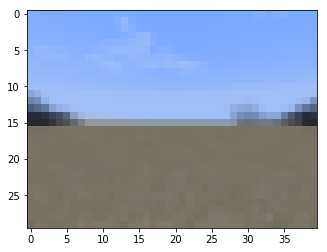

I'm in the desert and see mountains in the distance


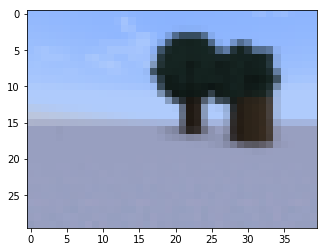

I'm standing in a snowy field and see some trees


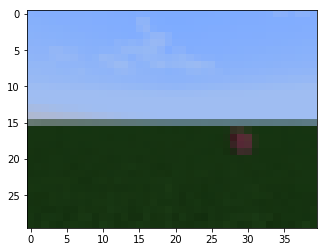

I'm in a grassy field and see a pig


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.show()

print(' '.join(captions[0]))


plt.imshow(images[1])
plt.show()

print(' '.join(captions[1]))


plt.imshow(images[2])
plt.show()

print(' '.join(captions[2]))


First, we need to set up our captions for consumption by the Neural Network.  To do this, we will need to take our list of lists of words and turn it into a Tensor with dimensions

data point x sequence step

Now, you might be thinking, don't we need this to be a One-Hot encoding?  And the answer is "Yes", but we will be using a special embedding layer as the input to our LSTM that goes from One-Hot index to a vector of trainable weights.  In our case, this won't make much difference, but in datasets that have to cover an entire language it means we can have a Tensor filled with indices that get reduced down to a smaller dimensional space (say from 1,000,000 words down to a 256 dimensional vector) instead of keeping around a sparesely filled Tensor (that would have to have a million mostly unused entries).

For the sake of being able to batch (instead of running one at a time) we will need to pad all of our sequences to the length of the largest sequence found in our dataset.

1. Loop through the captions and construct a list consisting of the lengths (plus one -- we'll get to this in a second) of the captions

2. Find the maximum of those lengths

3. Go through all of the captions and construct the one-hot encoding

The easiest way to construct the one-hot encoding is to use a list comprehension for each line in the caption

`one_hot = [expression_that_turns_a_word_into_an_index(word) for word in caption]`

(Think about what we have that can go from word to index)

However, this isn't quite all we need to do.  As it is, we have captions with different lengths, and PyTorch doesn't allow for jagged Tensors, so we will need to pad our Tensors (this step wouldn't be required if we were doing non-batched SGD, but we will be batching so it is required).  Even if we didn't want to pad our sequences, we would most likely want to use a special "end of sequence" word to indicate when to stop the auto-regressive generation (here we use `'<END>'`.

So instead of the above we should do:


`one_hot = [expression_that_turns_a_word_into_an_index(word) for word in caption] + [expression_that_turns_a_word_into_an_index('<END>')] * number_of_tokens_to_add_to_get_to_max_len`


and we'll do that for every caption found in `captions`


(Think about how many tokens you need to add to a sequence to reach the length of the maximum sequence.  If the left list is the same size as the maximum sequence how many tokens do you add?  If it is of size 0, how many tokens do you add?)

We then need to turn the list of lists of caption indices into a tensor --

`caption_ids = torch.tensor(caption_ids, dtype=torch.long)`





In [4]:
captions = data[4]

lengths = [] #to hold the list of caption lengths
count = 0

for row in captions:
    lengths.append(len(row))

#TODO calculate the maximum length + 1 for the captions

max_len = max(lengths) + 1

#TODO turn the captions into a list of lists of integer indices indicating the one-hot encoding 
#they should all be padded with '<END>' at the end up to the maximum length + 1 calculated above

caption_ids = None

#for i in range(len(captions)):
 #   one_hot = [vocab2index[column] for column in captions[i]] + [vocab2index['<END>']] * (max_len - captionLengths[i])
    
caption_ids = [[vocab2index[word] for word in caption] + [vocab2index['<END>']] * (max_len - len(caption)) for caption in captions]

caption_ids = torch.tensor(caption_ids, dtype=torch.long)

One final thing, to use the padding and batching, we would need to sort our inputs so that they are in descending order by length. 

I've actually found better results by randomly shuffling the data, so we'll be doing that, however we do need our array of lengths to be set to the maximum length, or Torch will get mad at us for having data in non-descending order.

In [5]:
lengths = [max_len]*len(lengths) #max_len is 19

print(lengths)

[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,

As of now `images` is a list of numpy arrays (height x width x color channels) and we want to turn it into a 4-dimensional PyTorch Tensor with dimensions:

data point x color x height x width

First you will want to turn the list of images into a numpy Tensor with `np.array()`
This will have dimensions:

data point x height x width x color

You will then want to convert this into a PyTorch tensor via `torch.from_numpy()`

which will still have the dimensions:

data point x height x width x color

You will then want to use `.permute((dim1, dim2, dim3, dim4))` on the PyTorch Tensor which will rearrange the order of the dimensions.

e.g. If you did `imageTensor.permute((3,2,1,0))` on a tensor with the dimensions 

data point x height x width x color

it would produce a tensor with dimensions

color x height x width x data point

i.e. the 4th dimension is now first, the 3rd is now 2nd, the 2nd is now third and the first is last (0 indexed of course) 



In [6]:
#TODO turn the above image array into a Tensor

#list of numpy images to numpy tensor
imageTensorNP = np.array(images)

#numpy tensor to PyTorch tensor
imageTensor = torch.from_numpy(imageTensorNP)

#pemute the PyTorch to be (data points, channels, height, width) instead of (data points, height, width, channels)
#batch_size, channels, height, width
imageTensor = imageTensor.permute((0,3,1,2))

print(imageTensor.shape)

torch.Size([1000, 3, 30, 40])


Ok, we've set our data up, now we need to construct our networks.  We will be constructing two networks here.  

To do this we will be crafting custom Modules.  A Module in PyTorch can be thought of as a custom layer or set of layers.  Here we will be using them to contain a number of different layers.  The only two things we need in a Module are:

`__init__` -- The constructor

`forward` -- What the module does in the forward pass

PyTorch is really nice and uses a technique known as **autograd** that automatically computes the derivatives and makes the backwards pass on its own (assuming we are using functions that it knows how to differentiate).  We can even use arbitrary mathematics in our forward pass (assuming PyTorch knows how to differentiate the functions we are using).




First let's make the Convolutional Encoder:
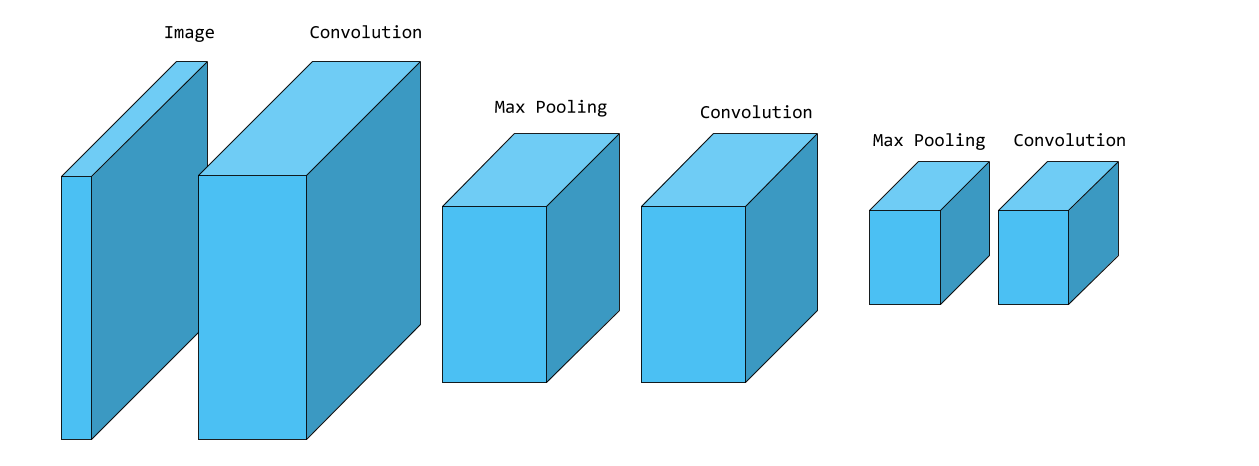

Our Encoder will take in a number of parameters:

`channels` the number of filters we wish to use in our convolutions

`embedding_size` the size of the vector that we will be encoding into

For the sake of this model, we will be constructing an encoder with 3 convolutional layers.

In the `__init__` method is where you will want to construct your layers -- for each layer you should construct:

`torch.nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding)`

The convolutional layer -- 
I suggest using `kernel_size=3, stride=1, padding=1` for now, but later you can experiment with this.


`torch.nn.BatchNorm2d(channels)` -- a Batch Normalization layer applied after the convolution.  Batch normalization is a regularization technique for Convolutional Neural Networks that scales the output of the convolution to a better range

`torch.nn.MaxPool2d(kernel_size, stride, padding)` -- the Max Pooling layer -- I suggest using kernel_size=2, stride=2, padding=0

After constructing a `Conv2d, BatchNorm2d,` and `MaxPool2d` for each of the 3 layers, we will need to construct a `Linear` layer to go from the output of the final max pooling to the size of our embedding.

Now, at this point, it's a little tricky to figure out the dimensionality of the final max pooling (you can calculate it, knowing the # of channels, the kernel sizes, the strides, and the padding, but that's a bit tricky) -- put a placeholder number (say 999) in for the input_dimension for now.  This will eventually give you the error when you try to train your model below:

"...size mismatch, m1: [1 x ???], m2: [999 x 512]"

You will then need to replace the 999 with what is found in ??? -- note, that will differ based on the number of channels, so your `Linear` layer should be something like `Linear(channels*CONSTANT, embedding_size)` where `channels*CONSTANT` equals ???


### Things to think about for the constructor:

1. How many input channels does the first Convolutional layer have?  

2. How many input channels does the second have?

3. How many output channels does the first CNN layer have?

4. How many output channels does the second have?


Next, we need to use all of our constructed layers in our forward pass.

Assuming you've named your layers as:

`self.conv{i} self.bn{i} self.pool{i}`

e.g. the first layer would be:

`self.conv1, self.bn1, self.pool1`

You can apply them a la:

`#output after first convolution`

`x = self.pool1(F.relu(self.bn1(self.conv1(x))))`

After doing this for all of the layers, we will need to flatten our learned features.  The easiest way to do this is via `.reshape()`.

`.reshape()` takes a tensor and turns it into a Tensor with the specified dimensions:

e.g.

`twoByThree = tensor.reshape(2,3)` would take any tensor that had 6 elements and put it into one that was 2 x 3

a nice thing that PyTorch lets us do is use `-1` as a filler that will be figured out from the other dimensions, so since we want to go to from a 'data points x channels x ??unknown reduced width?? x ??unknown reduced height??' Tensor to a 'data points x (channels * ??unknown reduced width?? * ??unknown reduced height??)' we can just do:

`x = x.reshape(x.size(0), -1)`

Apply the final `Linear` layer and a `relu` activation and return the output of all of this

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, channels, embedding_size):
        super(EncoderCNN, self).__init__()
        
        #TODO set up you Encoder CNN
        self.channels = channels
        #Input channels = 3
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(channels)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv2 = torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(channels)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.conv3 = torch.nn.Conv2d(in_channels=channels, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(channels)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.embed = torch.nn.Linear(in_features=15*channels, out_features=embedding_size)
        
    def forward(self, x):
        #TODO apply the 3 convolutional layers (convolution, batch norm, relu, pool)
        
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        
        #TODO reshape the data
        
        x = x.reshape(x.size(0), -1)
        
        #TODO embed the output and apply a ReLU activation
        
        x = F.relu(self.embed(x)) #relu
        
        return x

Now we need to construct our LSTM based Decoder.

Our Decoder takes in a few more parameters than our Encoder did.

`embedding_size` -- the size of the embedding, this should match the embedding_size above

`hidden_size` -- the number of hidden nodes in each LSTM layer

`vocab_size` -- the number of unique words in our vocabulary

`num_layers` -- the number of LSTM layers to use


As mentioned above, we will be using an `Embedding` layer to go from One-Hot indices into a embedded space (of the same dimensionality as our EncoderCNN embeds into, of course).

So, we need to construct a `nn.Embedding(vocab_size, embedding_size)` that will take our inputs (currently integers indicating the one-hot encoding index) and embed them into a different dimensionality (our provided embedding size).


Then we construct the LSTM layers -- unlike above, the LSTM module in PyTorch allows us to construct all of our layers in 1 module `nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)`  -- since we are doing batching, we need to tell our LSTM that it can batch across our first dimension.

Finally, after the LSTMs we will need to do a Softmax regression going to the size of our vocab (since we are predicting words from our vocab) -- so we need a `nn.Linear(hidden_size, vocab_size)`


In the forward pass, we need to:

1. Embed the captions
2. Concatenate the EncoderCNN features to the embedded captions
3. Pack the concatenated sequence so that we can do batching
4. Call the LSTM layer on the packed sequence
5. Apply the linear layer -- in a move that will maybe seem a bit confusing here, **don't** apply a Softmax activation


2. and 3. are a little unintuitive, so they are taken care of for you 


the output of calling the LSTM on the packed sequence are:

`output, (h_n, c_n) = self.lstm(????)` 

where 

`output` is "tensor containing the output features (h_t) from the last layer of the LSTM, for each t." If we only cared about the last output feature, we could use (h_n and c_n), but since we are doing a decoding of all of our steps, we instead will use the output (again, since we are using the packed_padded_sequence, we need to do things a little differently, and will only be using `output[0]`) 

Apply the `Linear` activation to `output[0]` and return that.

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        
        #TODO -- set up the parameters for the Decoder LSTM
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        #TODO 1. Embed
        embeddings = self.embed(captions)
        
        #2. Concatenate the encoded features
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        #3. Pack the padded sequence
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        
        #TODO 4. Call the LSTM layer on the packed sequence
        output, (h_n, c_n) = self.lstm(packed)
        
        #TODO 5. Apply the linear output
        outputs = self.linear(output[0])
        
        return outputs
        
    
 
    def sample(self, features, states=None):
        #This does a greedy decoding ( the outputs.max line)
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          
            outputs = self.linear(hiddens.squeeze(1))            
            _, predicted = outputs.max(1)                        
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       
            inputs = inputs.unsqueeze(1)                         
        sampled_ids = torch.stack(sampled_ids, 1)                
        return sampled_ids

Now that we have defined our Modules, we construct them here.

In [9]:
embed_size = 512
hidden_size = 256
channels = 256
num_layers = 3

encoder = EncoderCNN(channels, embed_size)
decoder = DecoderRNN(embed_size,hidden_size, len(vocab), num_layers)

We need to set up our parameters (gotten from our modules by calling `.parameters()`) and our optimizer (I recommend the Adam (no relation) optimizer).

Earlier, we didn't apply a Softmax layer, and that's because Torch gives us a special loss function `nn.CrossEntropyLoss` that combines a standard Softmax activation and Negative Log Cross Entropy loss into one (running a bit faster and resulting in better numerical stability).

In [10]:
learning_rate =0.0001
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.parameters()) 
optimizer = torch.optim.Adam(params, lr=learning_rate)

Now it is time to train our model.  Train the model until it seems like it has converged -- Loss around 0.1-0.2 is what I found to be acceptable.

In [11]:
import random
batch_size = 4
num_epochs = 100
log_step = 10
batches = list(range(0,imageTensor.shape[0],batch_size))

for epoch in range(num_epochs):
    random.shuffle(batches)
    for bid, batch in enumerate(batches):
        batch_image = imageTensor[batch:batch+batch_size,:,:,:]
        batch_captions = caption_ids[batch:batch+batch_size,:]
        batch_lengths = lengths[batch:batch+batch_size]
        features = encoder(batch_image)
        outputs = decoder(features, batch_captions, batch_lengths)
        targets = pack_padded_sequence(batch_captions, batch_lengths, batch_first=True)[0]
            
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        if bid % log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, num_epochs, bid,len(batches),  loss.item(), np.exp(loss.item()))) 

Epoch [0/100], Step [0/250], Loss: 3.4643, Perplexity: 31.9541
Epoch [0/100], Step [10/250], Loss: 3.3383, Perplexity: 28.1725
Epoch [0/100], Step [20/250], Loss: 3.0448, Perplexity: 21.0056
Epoch [0/100], Step [30/250], Loss: 2.1209, Perplexity: 8.3384
Epoch [0/100], Step [40/250], Loss: 2.2606, Perplexity: 9.5889
Epoch [0/100], Step [50/250], Loss: 1.6753, Perplexity: 5.3402
Epoch [0/100], Step [60/250], Loss: 1.6803, Perplexity: 5.3673
Epoch [0/100], Step [70/250], Loss: 1.4880, Perplexity: 4.4282
Epoch [0/100], Step [80/250], Loss: 1.8249, Perplexity: 6.2023
Epoch [0/100], Step [90/250], Loss: 1.4642, Perplexity: 4.3239
Epoch [0/100], Step [100/250], Loss: 1.5613, Perplexity: 4.7650
Epoch [0/100], Step [110/250], Loss: 1.5635, Perplexity: 4.7755
Epoch [0/100], Step [120/250], Loss: 1.5633, Perplexity: 4.7745
Epoch [0/100], Step [130/250], Loss: 1.3706, Perplexity: 3.9376
Epoch [0/100], Step [140/250], Loss: 1.2976, Perplexity: 3.6604
Epoch [0/100], Step [150/250], Loss: 1.2757, Per

Epoch [5/100], Step [40/250], Loss: 0.2152, Perplexity: 1.2401
Epoch [5/100], Step [50/250], Loss: 0.2942, Perplexity: 1.3421
Epoch [5/100], Step [60/250], Loss: 0.2477, Perplexity: 1.2811
Epoch [5/100], Step [70/250], Loss: 0.1648, Perplexity: 1.1791
Epoch [5/100], Step [80/250], Loss: 0.5157, Perplexity: 1.6747
Epoch [5/100], Step [90/250], Loss: 0.1940, Perplexity: 1.2141
Epoch [5/100], Step [100/250], Loss: 0.2436, Perplexity: 1.2758
Epoch [5/100], Step [110/250], Loss: 0.3727, Perplexity: 1.4517
Epoch [5/100], Step [120/250], Loss: 0.2884, Perplexity: 1.3342
Epoch [5/100], Step [130/250], Loss: 0.2340, Perplexity: 1.2636
Epoch [5/100], Step [140/250], Loss: 0.2270, Perplexity: 1.2548
Epoch [5/100], Step [150/250], Loss: 0.1907, Perplexity: 1.2101
Epoch [5/100], Step [160/250], Loss: 0.1770, Perplexity: 1.1936
Epoch [5/100], Step [170/250], Loss: 0.2538, Perplexity: 1.2889
Epoch [5/100], Step [180/250], Loss: 0.2257, Perplexity: 1.2532
Epoch [5/100], Step [190/250], Loss: 0.2945, P

Epoch [10/100], Step [80/250], Loss: 0.1374, Perplexity: 1.1472
Epoch [10/100], Step [90/250], Loss: 0.1344, Perplexity: 1.1438
Epoch [10/100], Step [100/250], Loss: 0.2058, Perplexity: 1.2285
Epoch [10/100], Step [110/250], Loss: 0.1753, Perplexity: 1.1916
Epoch [10/100], Step [120/250], Loss: 0.1320, Perplexity: 1.1411
Epoch [10/100], Step [130/250], Loss: 0.1469, Perplexity: 1.1582
Epoch [10/100], Step [140/250], Loss: 0.1248, Perplexity: 1.1329
Epoch [10/100], Step [150/250], Loss: 0.1369, Perplexity: 1.1467
Epoch [10/100], Step [160/250], Loss: 0.1612, Perplexity: 1.1749
Epoch [10/100], Step [170/250], Loss: 0.1460, Perplexity: 1.1572
Epoch [10/100], Step [180/250], Loss: 0.1926, Perplexity: 1.2124
Epoch [10/100], Step [190/250], Loss: 0.2190, Perplexity: 1.2448
Epoch [10/100], Step [200/250], Loss: 0.2147, Perplexity: 1.2395
Epoch [10/100], Step [210/250], Loss: 0.1972, Perplexity: 1.2180
Epoch [10/100], Step [220/250], Loss: 0.2896, Perplexity: 1.3359
Epoch [10/100], Step [230/2

Epoch [15/100], Step [100/250], Loss: 0.1456, Perplexity: 1.1567
Epoch [15/100], Step [110/250], Loss: 0.1019, Perplexity: 1.1073
Epoch [15/100], Step [120/250], Loss: 0.1613, Perplexity: 1.1750
Epoch [15/100], Step [130/250], Loss: 0.2036, Perplexity: 1.2259
Epoch [15/100], Step [140/250], Loss: 0.1438, Perplexity: 1.1546
Epoch [15/100], Step [150/250], Loss: 0.2030, Perplexity: 1.2251
Epoch [15/100], Step [160/250], Loss: 0.2679, Perplexity: 1.3072
Epoch [15/100], Step [170/250], Loss: 0.1585, Perplexity: 1.1717
Epoch [15/100], Step [180/250], Loss: 0.1573, Perplexity: 1.1704
Epoch [15/100], Step [190/250], Loss: 0.1702, Perplexity: 1.1855
Epoch [15/100], Step [200/250], Loss: 0.1139, Perplexity: 1.1206
Epoch [15/100], Step [210/250], Loss: 0.1471, Perplexity: 1.1584
Epoch [15/100], Step [220/250], Loss: 0.1657, Perplexity: 1.1802
Epoch [15/100], Step [230/250], Loss: 0.2473, Perplexity: 1.2805
Epoch [15/100], Step [240/250], Loss: 0.1946, Perplexity: 1.2148
Epoch [16/100], Step [0/2

Epoch [20/100], Step [120/250], Loss: 0.1684, Perplexity: 1.1834
Epoch [20/100], Step [130/250], Loss: 0.0992, Perplexity: 1.1043
Epoch [20/100], Step [140/250], Loss: 0.1169, Perplexity: 1.1241
Epoch [20/100], Step [150/250], Loss: 0.0952, Perplexity: 1.0998
Epoch [20/100], Step [160/250], Loss: 0.0911, Perplexity: 1.0954
Epoch [20/100], Step [170/250], Loss: 0.1181, Perplexity: 1.1254
Epoch [20/100], Step [180/250], Loss: 0.0904, Perplexity: 1.0946
Epoch [20/100], Step [190/250], Loss: 0.2036, Perplexity: 1.2258
Epoch [20/100], Step [200/250], Loss: 0.2095, Perplexity: 1.2331
Epoch [20/100], Step [210/250], Loss: 0.0800, Perplexity: 1.0833
Epoch [20/100], Step [220/250], Loss: 0.1393, Perplexity: 1.1494
Epoch [20/100], Step [230/250], Loss: 0.1371, Perplexity: 1.1469
Epoch [20/100], Step [240/250], Loss: 0.1330, Perplexity: 1.1422
Epoch [21/100], Step [0/250], Loss: 0.0641, Perplexity: 1.0662
Epoch [21/100], Step [10/250], Loss: 0.0641, Perplexity: 1.0662
Epoch [21/100], Step [20/250

Epoch [25/100], Step [140/250], Loss: 0.1373, Perplexity: 1.1471
Epoch [25/100], Step [150/250], Loss: 0.1218, Perplexity: 1.1295
Epoch [25/100], Step [160/250], Loss: 0.2173, Perplexity: 1.2427
Epoch [25/100], Step [170/250], Loss: 0.0903, Perplexity: 1.0945
Epoch [25/100], Step [180/250], Loss: 0.0877, Perplexity: 1.0916
Epoch [25/100], Step [190/250], Loss: 0.1780, Perplexity: 1.1948
Epoch [25/100], Step [200/250], Loss: 0.1158, Perplexity: 1.1228
Epoch [25/100], Step [210/250], Loss: 0.0741, Perplexity: 1.0769
Epoch [25/100], Step [220/250], Loss: 0.1280, Perplexity: 1.1365
Epoch [25/100], Step [230/250], Loss: 0.1840, Perplexity: 1.2020
Epoch [25/100], Step [240/250], Loss: 0.2151, Perplexity: 1.2400
Epoch [26/100], Step [0/250], Loss: 0.0754, Perplexity: 1.0783
Epoch [26/100], Step [10/250], Loss: 0.0880, Perplexity: 1.0920
Epoch [26/100], Step [20/250], Loss: 0.1283, Perplexity: 1.1369
Epoch [26/100], Step [30/250], Loss: 0.0571, Perplexity: 1.0588
Epoch [26/100], Step [40/250],

Epoch [30/100], Step [160/250], Loss: 0.0916, Perplexity: 1.0960
Epoch [30/100], Step [170/250], Loss: 0.1520, Perplexity: 1.1642
Epoch [30/100], Step [180/250], Loss: 0.0678, Perplexity: 1.0702
Epoch [30/100], Step [190/250], Loss: 0.0496, Perplexity: 1.0509
Epoch [30/100], Step [200/250], Loss: 0.1191, Perplexity: 1.1265
Epoch [30/100], Step [210/250], Loss: 0.0567, Perplexity: 1.0583
Epoch [30/100], Step [220/250], Loss: 0.2032, Perplexity: 1.2253
Epoch [30/100], Step [230/250], Loss: 0.1061, Perplexity: 1.1119
Epoch [30/100], Step [240/250], Loss: 0.2217, Perplexity: 1.2482
Epoch [31/100], Step [0/250], Loss: 0.1245, Perplexity: 1.1326
Epoch [31/100], Step [10/250], Loss: 0.1287, Perplexity: 1.1374
Epoch [31/100], Step [20/250], Loss: 0.1100, Perplexity: 1.1163
Epoch [31/100], Step [30/250], Loss: 0.0748, Perplexity: 1.0777
Epoch [31/100], Step [40/250], Loss: 0.0796, Perplexity: 1.0828
Epoch [31/100], Step [50/250], Loss: 0.1133, Perplexity: 1.1200
Epoch [31/100], Step [60/250], L

Epoch [35/100], Step [180/250], Loss: 0.1567, Perplexity: 1.1697
Epoch [35/100], Step [190/250], Loss: 0.0949, Perplexity: 1.0996
Epoch [35/100], Step [200/250], Loss: 0.1094, Perplexity: 1.1156
Epoch [35/100], Step [210/250], Loss: 0.2116, Perplexity: 1.2356
Epoch [35/100], Step [220/250], Loss: 0.0621, Perplexity: 1.0641
Epoch [35/100], Step [230/250], Loss: 0.3049, Perplexity: 1.3565
Epoch [35/100], Step [240/250], Loss: 0.1011, Perplexity: 1.1064
Epoch [36/100], Step [0/250], Loss: 0.0544, Perplexity: 1.0559
Epoch [36/100], Step [10/250], Loss: 0.1023, Perplexity: 1.1077
Epoch [36/100], Step [20/250], Loss: 0.0375, Perplexity: 1.0382
Epoch [36/100], Step [30/250], Loss: 0.1529, Perplexity: 1.1652
Epoch [36/100], Step [40/250], Loss: 0.2026, Perplexity: 1.2246
Epoch [36/100], Step [50/250], Loss: 0.0543, Perplexity: 1.0558
Epoch [36/100], Step [60/250], Loss: 0.0799, Perplexity: 1.0832
Epoch [36/100], Step [70/250], Loss: 0.0788, Perplexity: 1.0820
Epoch [36/100], Step [80/250], Los

Epoch [40/100], Step [200/250], Loss: 0.1280, Perplexity: 1.1366
Epoch [40/100], Step [210/250], Loss: 0.0641, Perplexity: 1.0662
Epoch [40/100], Step [220/250], Loss: 0.0783, Perplexity: 1.0815
Epoch [40/100], Step [230/250], Loss: 0.0716, Perplexity: 1.0743
Epoch [40/100], Step [240/250], Loss: 0.0570, Perplexity: 1.0586
Epoch [41/100], Step [0/250], Loss: 0.1594, Perplexity: 1.1728
Epoch [41/100], Step [10/250], Loss: 0.1210, Perplexity: 1.1286
Epoch [41/100], Step [20/250], Loss: 0.1294, Perplexity: 1.1382
Epoch [41/100], Step [30/250], Loss: 0.0363, Perplexity: 1.0369
Epoch [41/100], Step [40/250], Loss: 0.0386, Perplexity: 1.0393
Epoch [41/100], Step [50/250], Loss: 0.2507, Perplexity: 1.2850
Epoch [41/100], Step [60/250], Loss: 0.0938, Perplexity: 1.0983
Epoch [41/100], Step [70/250], Loss: 0.1063, Perplexity: 1.1122
Epoch [41/100], Step [80/250], Loss: 0.0930, Perplexity: 1.0975
Epoch [41/100], Step [90/250], Loss: 0.0480, Perplexity: 1.0492
Epoch [41/100], Step [100/250], Loss

Epoch [45/100], Step [220/250], Loss: 0.0980, Perplexity: 1.1030
Epoch [45/100], Step [230/250], Loss: 0.1358, Perplexity: 1.1455
Epoch [45/100], Step [240/250], Loss: 0.0953, Perplexity: 1.1000
Epoch [46/100], Step [0/250], Loss: 0.1064, Perplexity: 1.1122
Epoch [46/100], Step [10/250], Loss: 0.0738, Perplexity: 1.0766
Epoch [46/100], Step [20/250], Loss: 0.0786, Perplexity: 1.0817
Epoch [46/100], Step [30/250], Loss: 0.1158, Perplexity: 1.1227
Epoch [46/100], Step [40/250], Loss: 0.0688, Perplexity: 1.0712
Epoch [46/100], Step [50/250], Loss: 0.1193, Perplexity: 1.1267
Epoch [46/100], Step [60/250], Loss: 0.1840, Perplexity: 1.2021
Epoch [46/100], Step [70/250], Loss: 0.1409, Perplexity: 1.1513
Epoch [46/100], Step [80/250], Loss: 0.0804, Perplexity: 1.0837
Epoch [46/100], Step [90/250], Loss: 0.0708, Perplexity: 1.0733
Epoch [46/100], Step [100/250], Loss: 0.0813, Perplexity: 1.0847
Epoch [46/100], Step [110/250], Loss: 0.0798, Perplexity: 1.0831
Epoch [46/100], Step [120/250], Loss

Epoch [50/100], Step [240/250], Loss: 0.0505, Perplexity: 1.0518
Epoch [51/100], Step [0/250], Loss: 0.1007, Perplexity: 1.1059
Epoch [51/100], Step [10/250], Loss: 0.0330, Perplexity: 1.0335
Epoch [51/100], Step [20/250], Loss: 0.1287, Perplexity: 1.1373
Epoch [51/100], Step [30/250], Loss: 0.0955, Perplexity: 1.1002
Epoch [51/100], Step [40/250], Loss: 0.1378, Perplexity: 1.1477
Epoch [51/100], Step [50/250], Loss: 0.0351, Perplexity: 1.0357
Epoch [51/100], Step [60/250], Loss: 0.0768, Perplexity: 1.0798
Epoch [51/100], Step [70/250], Loss: 0.0721, Perplexity: 1.0747
Epoch [51/100], Step [80/250], Loss: 0.0785, Perplexity: 1.0816
Epoch [51/100], Step [90/250], Loss: 0.1438, Perplexity: 1.1546
Epoch [51/100], Step [100/250], Loss: 0.0760, Perplexity: 1.0789
Epoch [51/100], Step [110/250], Loss: 0.0316, Perplexity: 1.0322
Epoch [51/100], Step [120/250], Loss: 0.0520, Perplexity: 1.0534
Epoch [51/100], Step [130/250], Loss: 0.0280, Perplexity: 1.0284
Epoch [51/100], Step [140/250], Loss

Epoch [56/100], Step [10/250], Loss: 0.0551, Perplexity: 1.0566
Epoch [56/100], Step [20/250], Loss: 0.0329, Perplexity: 1.0334
Epoch [56/100], Step [30/250], Loss: 0.1019, Perplexity: 1.1073
Epoch [56/100], Step [40/250], Loss: 0.0200, Perplexity: 1.0202
Epoch [56/100], Step [50/250], Loss: 0.1127, Perplexity: 1.1193
Epoch [56/100], Step [60/250], Loss: 0.0594, Perplexity: 1.0612
Epoch [56/100], Step [70/250], Loss: 0.0436, Perplexity: 1.0445
Epoch [56/100], Step [80/250], Loss: 0.0563, Perplexity: 1.0579
Epoch [56/100], Step [90/250], Loss: 0.1113, Perplexity: 1.1178
Epoch [56/100], Step [100/250], Loss: 0.1488, Perplexity: 1.1604
Epoch [56/100], Step [110/250], Loss: 0.0521, Perplexity: 1.0535
Epoch [56/100], Step [120/250], Loss: 0.0902, Perplexity: 1.0944
Epoch [56/100], Step [130/250], Loss: 0.0475, Perplexity: 1.0486
Epoch [56/100], Step [140/250], Loss: 0.1568, Perplexity: 1.1698
Epoch [56/100], Step [150/250], Loss: 0.0232, Perplexity: 1.0235
Epoch [56/100], Step [160/250], Lo

Epoch [61/100], Step [30/250], Loss: 0.0495, Perplexity: 1.0507
Epoch [61/100], Step [40/250], Loss: 0.0201, Perplexity: 1.0203
Epoch [61/100], Step [50/250], Loss: 0.0873, Perplexity: 1.0912
Epoch [61/100], Step [60/250], Loss: 0.0725, Perplexity: 1.0752
Epoch [61/100], Step [70/250], Loss: 0.0349, Perplexity: 1.0355
Epoch [61/100], Step [80/250], Loss: 0.1093, Perplexity: 1.1155
Epoch [61/100], Step [90/250], Loss: 0.0854, Perplexity: 1.0891
Epoch [61/100], Step [100/250], Loss: 0.0996, Perplexity: 1.1047
Epoch [61/100], Step [110/250], Loss: 0.0259, Perplexity: 1.0262
Epoch [61/100], Step [120/250], Loss: 0.0861, Perplexity: 1.0899
Epoch [61/100], Step [130/250], Loss: 0.0546, Perplexity: 1.0561
Epoch [61/100], Step [140/250], Loss: 0.0652, Perplexity: 1.0673
Epoch [61/100], Step [150/250], Loss: 0.0322, Perplexity: 1.0327
Epoch [61/100], Step [160/250], Loss: 0.0261, Perplexity: 1.0264
Epoch [61/100], Step [170/250], Loss: 0.0897, Perplexity: 1.0938
Epoch [61/100], Step [180/250], 

Epoch [66/100], Step [50/250], Loss: 0.0303, Perplexity: 1.0308
Epoch [66/100], Step [60/250], Loss: 0.0289, Perplexity: 1.0294
Epoch [66/100], Step [70/250], Loss: 0.0393, Perplexity: 1.0401
Epoch [66/100], Step [80/250], Loss: 0.0235, Perplexity: 1.0238
Epoch [66/100], Step [90/250], Loss: 0.0333, Perplexity: 1.0339
Epoch [66/100], Step [100/250], Loss: 0.0983, Perplexity: 1.1033
Epoch [66/100], Step [110/250], Loss: 0.0575, Perplexity: 1.0592
Epoch [66/100], Step [120/250], Loss: 0.1223, Perplexity: 1.1301
Epoch [66/100], Step [130/250], Loss: 0.0585, Perplexity: 1.0602
Epoch [66/100], Step [140/250], Loss: 0.0198, Perplexity: 1.0200
Epoch [66/100], Step [150/250], Loss: 0.0141, Perplexity: 1.0142
Epoch [66/100], Step [160/250], Loss: 0.1273, Perplexity: 1.1358
Epoch [66/100], Step [170/250], Loss: 0.0984, Perplexity: 1.1035
Epoch [66/100], Step [180/250], Loss: 0.0870, Perplexity: 1.0909
Epoch [66/100], Step [190/250], Loss: 0.0330, Perplexity: 1.0335
Epoch [66/100], Step [200/250]

Epoch [71/100], Step [70/250], Loss: 0.0176, Perplexity: 1.0178
Epoch [71/100], Step [80/250], Loss: 0.1110, Perplexity: 1.1174
Epoch [71/100], Step [90/250], Loss: 0.0655, Perplexity: 1.0677
Epoch [71/100], Step [100/250], Loss: 0.0617, Perplexity: 1.0637
Epoch [71/100], Step [110/250], Loss: 0.0653, Perplexity: 1.0675
Epoch [71/100], Step [120/250], Loss: 0.0331, Perplexity: 1.0336
Epoch [71/100], Step [130/250], Loss: 0.0144, Perplexity: 1.0145
Epoch [71/100], Step [140/250], Loss: 0.0610, Perplexity: 1.0630
Epoch [71/100], Step [150/250], Loss: 0.1389, Perplexity: 1.1490
Epoch [71/100], Step [160/250], Loss: 0.0135, Perplexity: 1.0136
Epoch [71/100], Step [170/250], Loss: 0.0159, Perplexity: 1.0160
Epoch [71/100], Step [180/250], Loss: 0.0305, Perplexity: 1.0309
Epoch [71/100], Step [190/250], Loss: 0.0053, Perplexity: 1.0054
Epoch [71/100], Step [200/250], Loss: 0.0373, Perplexity: 1.0380
Epoch [71/100], Step [210/250], Loss: 0.0135, Perplexity: 1.0136
Epoch [71/100], Step [220/25

Epoch [76/100], Step [90/250], Loss: 0.0312, Perplexity: 1.0317
Epoch [76/100], Step [100/250], Loss: 0.0174, Perplexity: 1.0175
Epoch [76/100], Step [110/250], Loss: 0.0115, Perplexity: 1.0116
Epoch [76/100], Step [120/250], Loss: 0.0307, Perplexity: 1.0311
Epoch [76/100], Step [130/250], Loss: 0.0324, Perplexity: 1.0330
Epoch [76/100], Step [140/250], Loss: 0.0602, Perplexity: 1.0620
Epoch [76/100], Step [150/250], Loss: 0.0480, Perplexity: 1.0492
Epoch [76/100], Step [160/250], Loss: 0.0101, Perplexity: 1.0102
Epoch [76/100], Step [170/250], Loss: 0.0466, Perplexity: 1.0477
Epoch [76/100], Step [180/250], Loss: 0.0044, Perplexity: 1.0044
Epoch [76/100], Step [190/250], Loss: 0.0720, Perplexity: 1.0747
Epoch [76/100], Step [200/250], Loss: 0.1094, Perplexity: 1.1156
Epoch [76/100], Step [210/250], Loss: 0.0314, Perplexity: 1.0319
Epoch [76/100], Step [220/250], Loss: 0.0464, Perplexity: 1.0475
Epoch [76/100], Step [230/250], Loss: 0.0162, Perplexity: 1.0164
Epoch [76/100], Step [240/

Epoch [81/100], Step [110/250], Loss: 0.0198, Perplexity: 1.0200
Epoch [81/100], Step [120/250], Loss: 0.0099, Perplexity: 1.0099
Epoch [81/100], Step [130/250], Loss: 0.0077, Perplexity: 1.0077
Epoch [81/100], Step [140/250], Loss: 0.0738, Perplexity: 1.0766
Epoch [81/100], Step [150/250], Loss: 0.0266, Perplexity: 1.0270
Epoch [81/100], Step [160/250], Loss: 0.0257, Perplexity: 1.0261
Epoch [81/100], Step [170/250], Loss: 0.0111, Perplexity: 1.0112
Epoch [81/100], Step [180/250], Loss: 0.0811, Perplexity: 1.0845
Epoch [81/100], Step [190/250], Loss: 0.0632, Perplexity: 1.0653
Epoch [81/100], Step [200/250], Loss: 0.1297, Perplexity: 1.1385
Epoch [81/100], Step [210/250], Loss: 0.0587, Perplexity: 1.0605
Epoch [81/100], Step [220/250], Loss: 0.0659, Perplexity: 1.0681
Epoch [81/100], Step [230/250], Loss: 0.0019, Perplexity: 1.0019
Epoch [81/100], Step [240/250], Loss: 0.0332, Perplexity: 1.0337
Epoch [82/100], Step [0/250], Loss: 0.0228, Perplexity: 1.0231
Epoch [82/100], Step [10/25

Epoch [86/100], Step [130/250], Loss: 0.0181, Perplexity: 1.0183
Epoch [86/100], Step [140/250], Loss: 0.1232, Perplexity: 1.1311
Epoch [86/100], Step [150/250], Loss: 0.0355, Perplexity: 1.0362
Epoch [86/100], Step [160/250], Loss: 0.0547, Perplexity: 1.0562
Epoch [86/100], Step [170/250], Loss: 0.0028, Perplexity: 1.0028
Epoch [86/100], Step [180/250], Loss: 0.0621, Perplexity: 1.0641
Epoch [86/100], Step [190/250], Loss: 0.0073, Perplexity: 1.0073
Epoch [86/100], Step [200/250], Loss: 0.0414, Perplexity: 1.0423
Epoch [86/100], Step [210/250], Loss: 0.0695, Perplexity: 1.0719
Epoch [86/100], Step [220/250], Loss: 0.0461, Perplexity: 1.0472
Epoch [86/100], Step [230/250], Loss: 0.0364, Perplexity: 1.0370
Epoch [86/100], Step [240/250], Loss: 0.0149, Perplexity: 1.0150
Epoch [87/100], Step [0/250], Loss: 0.0397, Perplexity: 1.0405
Epoch [87/100], Step [10/250], Loss: 0.0685, Perplexity: 1.0709
Epoch [87/100], Step [20/250], Loss: 0.0130, Perplexity: 1.0130
Epoch [87/100], Step [30/250]

Epoch [91/100], Step [150/250], Loss: 0.0166, Perplexity: 1.0167
Epoch [91/100], Step [160/250], Loss: 0.0368, Perplexity: 1.0375
Epoch [91/100], Step [170/250], Loss: 0.0184, Perplexity: 1.0185
Epoch [91/100], Step [180/250], Loss: 0.0360, Perplexity: 1.0367
Epoch [91/100], Step [190/250], Loss: 0.0037, Perplexity: 1.0037
Epoch [91/100], Step [200/250], Loss: 0.0554, Perplexity: 1.0569
Epoch [91/100], Step [210/250], Loss: 0.0803, Perplexity: 1.0836
Epoch [91/100], Step [220/250], Loss: 0.0412, Perplexity: 1.0421
Epoch [91/100], Step [230/250], Loss: 0.1203, Perplexity: 1.1278
Epoch [91/100], Step [240/250], Loss: 0.0036, Perplexity: 1.0036
Epoch [92/100], Step [0/250], Loss: 0.0081, Perplexity: 1.0081
Epoch [92/100], Step [10/250], Loss: 0.0496, Perplexity: 1.0508
Epoch [92/100], Step [20/250], Loss: 0.0649, Perplexity: 1.0671
Epoch [92/100], Step [30/250], Loss: 0.0223, Perplexity: 1.0226
Epoch [92/100], Step [40/250], Loss: 0.0197, Perplexity: 1.0199
Epoch [92/100], Step [50/250], 

Epoch [96/100], Step [170/250], Loss: 0.0463, Perplexity: 1.0473
Epoch [96/100], Step [180/250], Loss: 0.0449, Perplexity: 1.0459
Epoch [96/100], Step [190/250], Loss: 0.0179, Perplexity: 1.0181
Epoch [96/100], Step [200/250], Loss: 0.0101, Perplexity: 1.0101
Epoch [96/100], Step [210/250], Loss: 0.0019, Perplexity: 1.0019
Epoch [96/100], Step [220/250], Loss: 0.0925, Perplexity: 1.0970
Epoch [96/100], Step [230/250], Loss: 0.0023, Perplexity: 1.0023
Epoch [96/100], Step [240/250], Loss: 0.0414, Perplexity: 1.0423
Epoch [97/100], Step [0/250], Loss: 0.0106, Perplexity: 1.0107
Epoch [97/100], Step [10/250], Loss: 0.0026, Perplexity: 1.0026
Epoch [97/100], Step [20/250], Loss: 0.0574, Perplexity: 1.0591
Epoch [97/100], Step [30/250], Loss: 0.0022, Perplexity: 1.0022
Epoch [97/100], Step [40/250], Loss: 0.0377, Perplexity: 1.0385
Epoch [97/100], Step [50/250], Loss: 0.0289, Perplexity: 1.0293
Epoch [97/100], Step [60/250], Loss: 0.0272, Perplexity: 1.0276
Epoch [97/100], Step [70/250], Lo

Now, let's see the fruits of our labor!

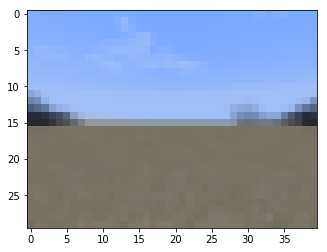

PREDICTED: I'm in the desert and see mountains in the distance
TRUTH:I'm in the desert and see mountains in the distance


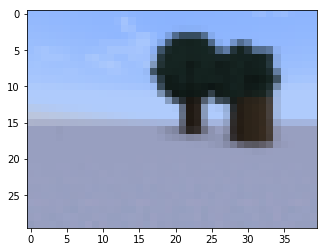

PREDICTED: I'm in a snowy field and see some trees
TRUTH:I'm standing in a snowy field and see some trees


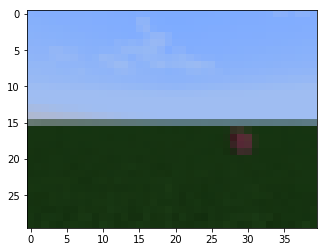

PREDICTED: I'm in a grassy field and see a pig
TRUTH:I'm in a grassy field and see a pig


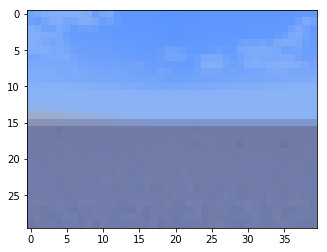

PREDICTED: I'm standing in a snowy field
TRUTH:I'm standing in a snowy field


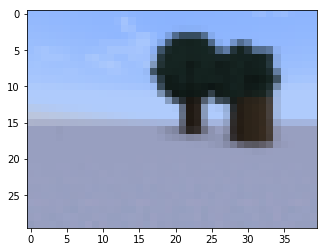

PREDICTED: I'm in a snowy field and see some trees
TRUTH:I'm standing in a snowy field and see some trees


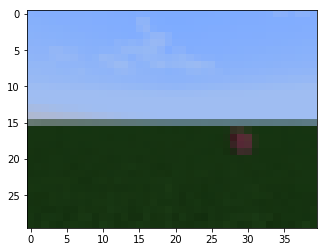

PREDICTED: I'm in a grassy field and see a pig
TRUTH:I'm in a grassy field and see a pig


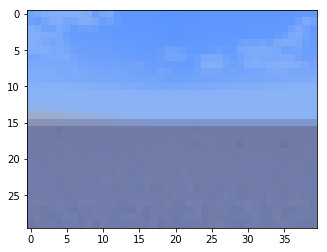

PREDICTED: I'm standing in a snowy field
TRUTH:I'm standing in a snowy field


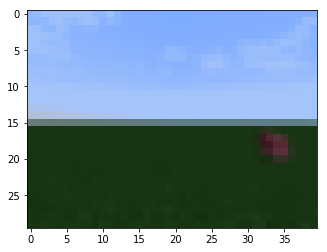

PREDICTED: I'm standing in a grassy field and see a pig
TRUTH:I'm standing in a grassy field and see a pig


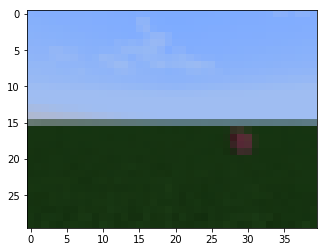

PREDICTED: I'm in a grassy field and see a cow
TRUTH:I'm in a grassy field and see a pig


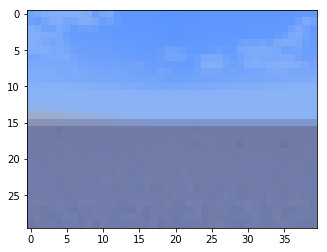

PREDICTED: I'm standing in a snowy field
TRUTH:I'm standing in a snowy field


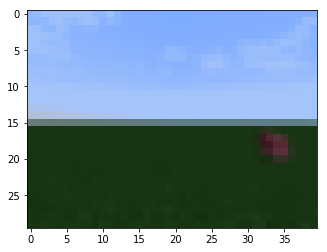

PREDICTED: I'm standing in a grassy field and see a cow
TRUTH:I'm standing in a grassy field and see a pig


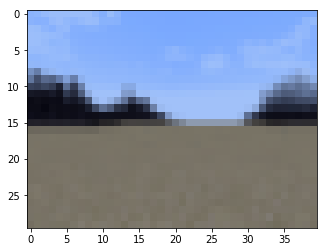

PREDICTED: I'm standing in the desert and see some mountains
TRUTH:I'm in the desert and see some mountains


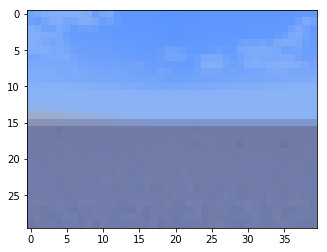

PREDICTED: I'm standing in a snowy field
TRUTH:I'm standing in a snowy field


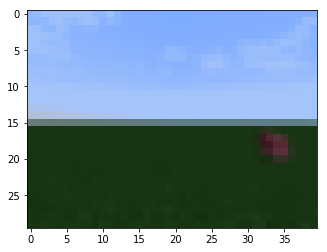

PREDICTED: I'm standing in a grassy field and see a pig
TRUTH:I'm standing in a grassy field and see a pig


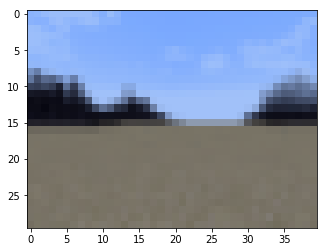

PREDICTED: I'm in the desert and see some mountains
TRUTH:I'm in the desert and see some mountains


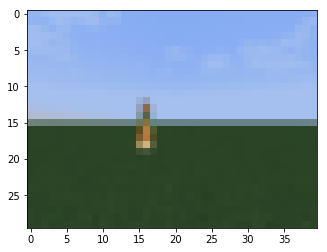

PREDICTED: I'm standing in a grassy field and see a zombie
TRUTH:I'm standing in a grassy field and see a zombie


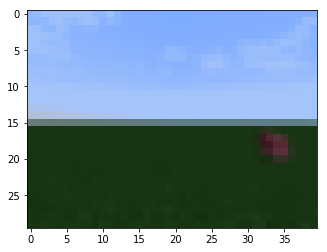

PREDICTED: I'm standing in a grassy field and see a pig
TRUTH:I'm standing in a grassy field and see a pig


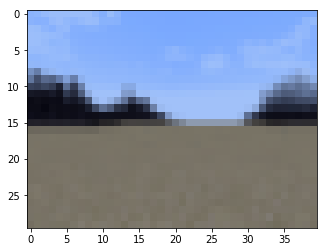

PREDICTED: I'm in the desert and see some mountains
TRUTH:I'm in the desert and see some mountains


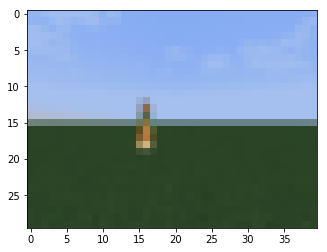

PREDICTED: I'm standing in a grassy field and see a zombie
TRUTH:I'm standing in a grassy field and see a zombie


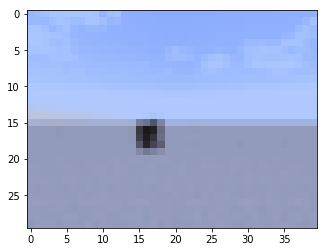

PREDICTED: I'm standing in a snowy field and see a cow
TRUTH:I'm standing in a snowy field and see a cow


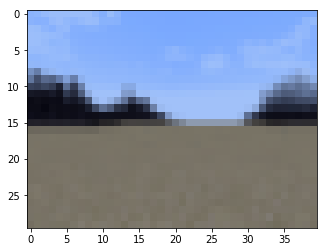

PREDICTED: I'm in the desert and see some mountains
TRUTH:I'm in the desert and see some mountains


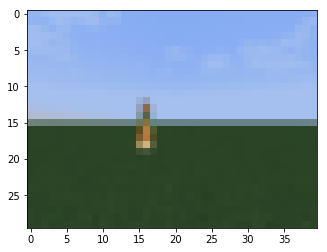

PREDICTED: I'm standing in a grassy field and see a zombie
TRUTH:I'm standing in a grassy field and see a zombie


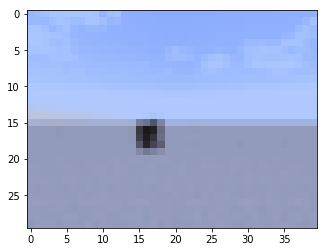

PREDICTED: I'm standing in a snowy field and see a cow
TRUTH:I'm standing in a snowy field and see a cow


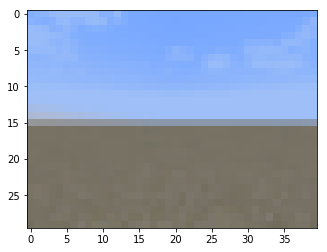

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


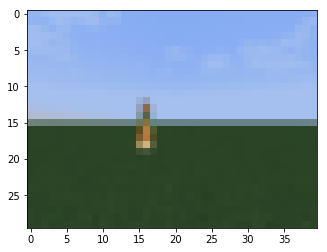

PREDICTED: I'm standing in a grassy field and see a zombie
TRUTH:I'm standing in a grassy field and see a zombie


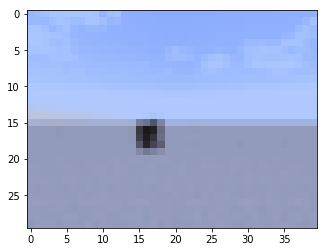

PREDICTED: I'm standing in a snowy field and see a cow
TRUTH:I'm standing in a snowy field and see a cow


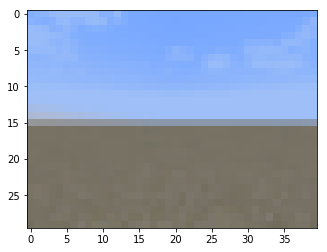

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


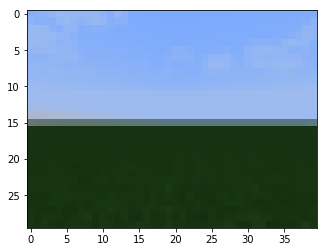

PREDICTED: I'm in a grassy field
TRUTH:I'm in a grassy field


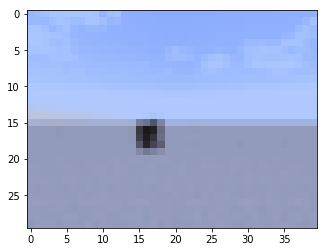

PREDICTED: I'm standing in a snowy field and see a cow
TRUTH:I'm standing in a snowy field and see a cow


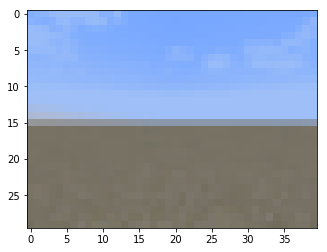

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


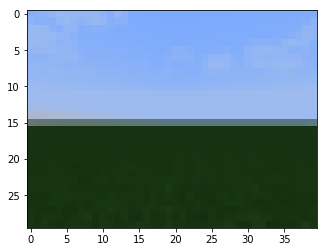

PREDICTED: I'm in a grassy field
TRUTH:I'm in a grassy field


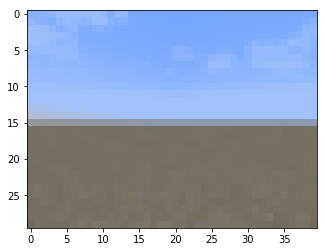

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


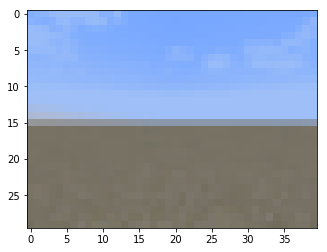

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


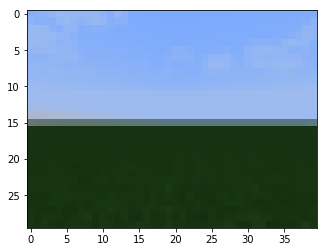

PREDICTED: I'm in a grassy field
TRUTH:I'm in a grassy field


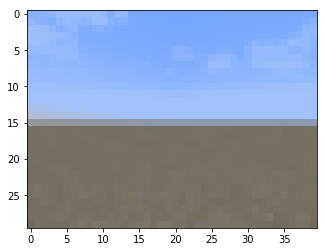

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


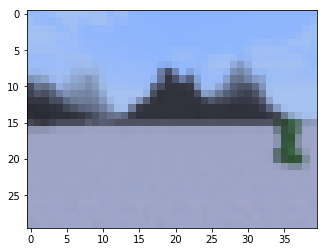

PREDICTED: I'm standing in a snowy field and see some mountains and a creeper
TRUTH:I'm standing in a snowy field and see some mountains and a creeper


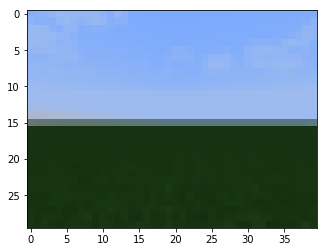

PREDICTED: I'm standing in a grassy field
TRUTH:I'm in a grassy field


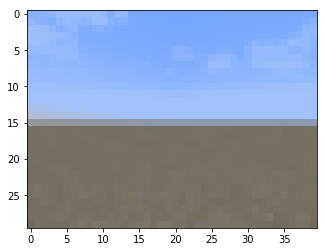

PREDICTED: I'm standing in the desert
TRUTH:I'm standing in the desert


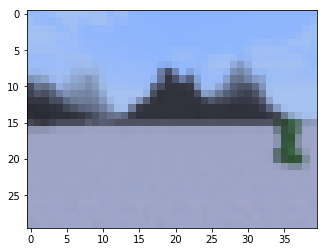

PREDICTED: I'm standing in a snowy field and see some mountains and a creeper
TRUTH:I'm standing in a snowy field and see some mountains and a creeper


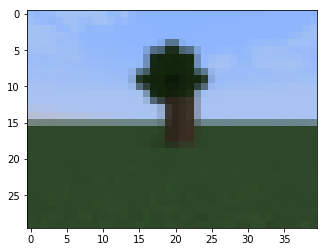

PREDICTED: I'm standing in a grassy field and see a lonely tree
TRUTH:I'm standing in a grassy field and see a lonely tree


In [12]:
#Change this to see how it handles different images

for batch in range(10):
    #batch = 5


    decoder.zero_grad()
    batch_image = imageTensor[batch:batch+batch_size,:,:,:]
    batch_captions = caption_ids[batch:batch+batch_size,:]
    features = encoder(batch_image)
    outputs = decoder.sample(features)

    for num,caption in enumerate(outputs):
        plt.imshow(images[batch+num])
        plt.show()
        print('PREDICTED: ' + ' '.join([index2vocab[w] for w in caption.numpy() if index2vocab[w] != '<END>']))
        print('TRUTH:' + ' '.join(captions[batch+ num]))

Extra Credit:

Try to play around with the architectures and see if you can get a better result than the model that I've lead you through.

Things to consider:

Different Convolutional Architecture

Regularization 

Different dimensions/numbers of layers

Attention

Beam-Search